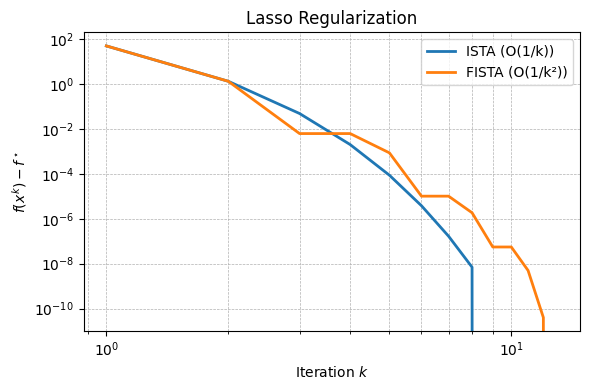

[LASSO] Skipped L-BFGS: L-BFGS only supports 'ridge' or 'elasticnet' (with alpha1 ≈ 0).


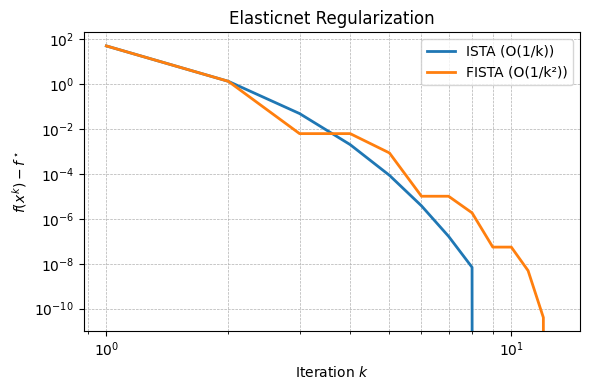

[ELASTICNET] Skipped L-BFGS: L-BFGS only supports smooth problems: alpha1 must be near 0.


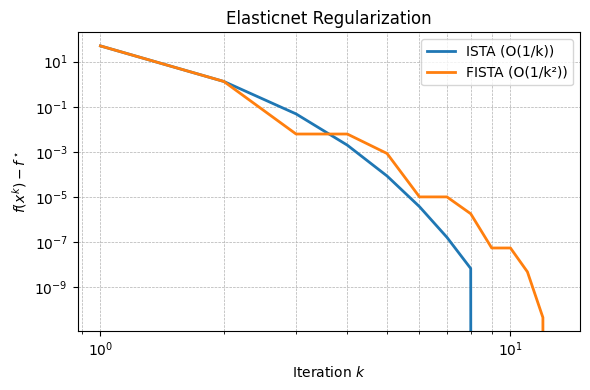

[ELASTICNET] Skipped L-BFGS: L-BFGS only supports smooth problems: alpha1 must be near 0.
[ELASTICNET] Skipped ISTA/FISTA: alpha1 ≈ 0 → smooth-only. Use L-BFGS.
[RIDGE] Skipped ISTA/FISTA: unsupported reg_type


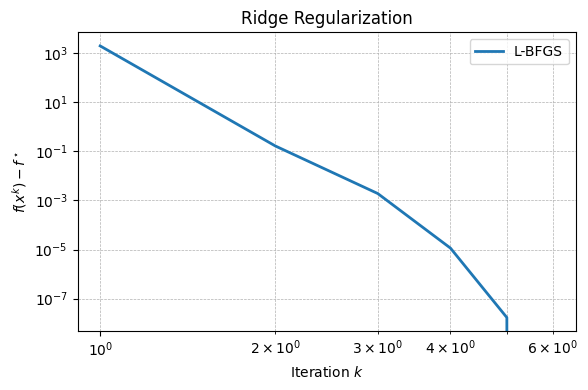

   method regularizer  alpha1  alpha2  n_iter    time_s    f_final  error_norm
0    ISTA       lasso  0.5000    0.00      10  0.000908   7.108271    9.371145
1   FISTA       lasso  0.5000    0.00      13  0.000711   7.108271    9.371145
2    ISTA  elasticnet  0.2000    0.05      10  0.000698   5.749968    9.370963
3   FISTA  elasticnet  0.2000    0.05      13  0.000886   5.749968    9.370963
4    ISTA  elasticnet  0.0001    0.50      10  0.001203   9.068880    9.372293
5   FISTA  elasticnet  0.0001    0.50      13  0.000685   9.068880    9.372293
6  L-BFGS  elasticnet  0.0000    0.50       6  0.000548   9.068258    9.372294
7  L-BFGS       ridge  0.0000    1.00       6  0.000387  14.125584    9.374034


In [135]:

# imports
from importlib import reload
import iterative_solvers
reload(iterative_solvers)
from iterative_solvers import fista_delta
from easy_boston_data import generate_easy_boston_like_data
from iterative_solvers import ista, fista
from lbfgs import LBFGSSolver
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# 1) data gen + standardization
A, b, x_true = generate_easy_boston_like_data(m=800, seed=42, noise_std=0.1)
A_mean, A_std = A.mean(axis=0), A.std(axis=0)
A = (A - A_mean) / A_std
b = b - b.mean()

# 2) Lasso, Elastic-Net, Ridge
reg_settings = [
    {"name": "lasso",      "alpha1": 0.5,   "alpha2": 0.0},
    {"name": "elasticnet", "alpha1": 0.2,   "alpha2": 0.05},
    {"name": "elasticnet", "alpha1": 1e-4,  "alpha2": 0.5},
    {"name": "elasticnet", "alpha1": 0.0,   "alpha2": 0.5},
    {"name": "ridge",      "alpha1": 0.0,   "alpha2": 1.0}
]

records = []

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    # --- ISTA / FISTA solo se valido ---
    if name in ("lasso", "elasticnet"):
        if name == "elasticnet" and a1 < 1e-6:
            print(f"[{name.upper()}] Skipped ISTA/FISTA: alpha1 ≈ 0 → smooth-only. Use L-BFGS.")
        else:
            try:
                # ISTA
                t0 = time.perf_counter()
                x_ista, obj_ista = ista(A, b,
                                        reg_type=name,
                                        alpha1=a1,
                                        alpha2=a2,
                                        max_iter=500)
                t_ista = time.perf_counter() - t0

                # FISTA
                t0 = time.perf_counter()
                x_fista, obj_fista = fista(A, b,
                                           reg_type=name,
                                           alpha1=a1,
                                           alpha2=a2,
                                           max_iter=500)
                t_fista = time.perf_counter() - t0

                # approximate best f*
                f_star = obj_fista[-1]

                # plot convergence
                gap_ista  = np.array(obj_ista)  - f_star
                gap_fista = np.array(obj_fista) - f_star
                env_ista  = np.minimum.accumulate(gap_ista)
                env_fista = np.minimum.accumulate(gap_fista)
                ks_ista  = np.arange(1, len(env_ista) + 1)
                ks_fista = np.arange(1, len(env_fista) + 1)

                fig, ax = plt.subplots(figsize=(6, 4))
                ax.loglog(ks_ista, env_ista,  '-', label="ISTA (O(1/k))", linewidth=2)
                ax.loglog(ks_fista, env_fista, '-', label="FISTA (O(1/k²))", linewidth=2)
                ax.set_title(f"{name.title()} Regularization")
                ax.set_xlabel("Iteration $k$")
                ax.set_ylabel(r"$f(x^k)-f^\star$")
                ax.grid(True, which='both', linestyle='--', linewidth=0.5)
                ax.legend()
                plt.tight_layout()
                plt.show()

                records.append({
                    "method":      "ISTA",
                    "regularizer": name,
                    "alpha1": a1,
                    "alpha2": a2,
                    "n_iter":      len(obj_ista),
                    "time_s":      t_ista,
                    "f_final":     obj_ista[-1],
                    "error_norm":  np.linalg.norm(x_ista - x_true)
                })

                records.append({
                    "method":      "FISTA",
                    "regularizer": name,
                    "alpha1": a1,
                    "alpha2": a2,
                    "n_iter":      len(obj_fista),
                    "time_s":      t_fista,
                    "f_final":     obj_fista[-1],
                    "error_norm":  np.linalg.norm(x_fista - x_true)
                })

            except ValueError as e:
                print(f"[{name.upper()}] Skipped ISTA/FISTA: {e}")
    else:
        print(f"[{name.upper()}] Skipped ISTA/FISTA: unsupported reg_type")

    # --- L-BFGS sempre tentato se valido ---
    try:
        solver = LBFGSSolver(reg_type=name, alpha1=a1, alpha2=a2)
        t0 = time.perf_counter()
        solver.fit(A, b)
        t_lbfgs = time.perf_counter() - t0

        records.append({
            "method":      "L-BFGS",
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter":      len(solver.history_),
            "time_s":      t_lbfgs,
            "f_final":     solver.final_obj_,
            "error_norm":  np.linalg.norm(solver.x_ - x_true)
        })

        if name == "ridge":
            obj_vals = solver.history_
            f_star = solver.final_obj_
            gap_lbfgs = np.array(obj_vals) - f_star
            env_lbfgs = np.minimum.accumulate(gap_lbfgs)
            ks = np.arange(1, len(env_lbfgs)+1)

            fig, ax = plt.subplots(figsize=(6, 4))
            ax.loglog(ks, env_lbfgs, '-', label="L-BFGS", linewidth=2)
            ax.set_title("Ridge Regularization")
            ax.set_xlabel("Iteration $k$")
            ax.set_ylabel(r"$f(x^k)-f^\star$")
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            ax.legend()
            plt.tight_layout()
            plt.show()

    except ValueError as e:
        print(f"[{name.upper()}] Skipped L-BFGS: {e}")


# Final table
df_summary = pd.DataFrame(records)
print(df_summary)


### 📋 Table Explanation – Optimization Results

Each row of the summary tables reports the performance of a given optimization method (e.g., ISTA, FISTA, FISTA-Delta, L-BFGS) applied to a specific regularization configuration.

#### 🔢 Columns:

- **method**: the algorithm used (`ISTA`, `FISTA`, `FISTA-DELTA`, `L-BFGS`)
- **regularizer**: type of regularization (`lasso`, `elasticnet`, or `ridge`)
- **alpha1**: coefficient of L1 regularization (sparsity)
- **alpha2**: coefficient of L2 regularization (ridge)
- **reg_group**: assigned group label based on regularization parameters:
  - `"EN-1"` → Elastic Net with strong L1 (e.g., alpha1 = 0.2)
  - `"EN-2"` → Elastic Net with weak L1 (e.g., alpha1 ≈ 1e-4)
  - `"EN-3"` → Elastic Net degenerate to Ridge (alpha1 = 0)
  - `"lasso"` or `"ridge"` explicitly labeled
- **n_iter**: number of iterations until stopping (based on step norm < ε)
- **time_s**: wall-clock runtime in seconds
- **f_final**: final objective value reached
- **f_opt**: best known value for this problem group
- **gap**: difference `f_final - f_opt` (non-negative)
- **converged**: boolean flag indicating whether `gap < 1e-6`
- **error_norm**: Euclidean norm `‖x - x_true‖`, i.e., distance to ground truth
- **delta** (only for FISTA-Delta): controls the inertial weight θₖ

These tables allow accurate comparison across solvers and problem regimes.


In [136]:
opt_per_group = df_summary.groupby(["regularizer", "alpha1", "alpha2"])["f_final"].min().rename("f_opt")
df_final = df_summary.merge(opt_per_group, on=["regularizer", "alpha1", "alpha2"])
df_final["gap"] = df_final["f_final"] - df_final["f_opt"]
df_final["converged"] = df_final["gap"] < 1e-6

def classify_group(row):
    if row["regularizer"] == "ridge":
        return "ridge"
    elif row["regularizer"] == "lasso":
        return "lasso"
    elif row["regularizer"] == "elasticnet":
        if np.isclose(row["alpha1"], 0.2, rtol=0, atol=1e-8):
            return "EN-1"
        elif np.isclose(row["alpha1"], 1e-4, rtol=0, atol=1e-8):
            return "EN-2"
        elif np.isclose(row["alpha1"], 0.0, rtol=0, atol=1e-12):
            return "EN-3"
        else:
            return "elasticnet-other"
    else:
        return row["regularizer"]



df_final["reg_group"] = df_final.apply(classify_group, axis=1)

cols = list(df_final.columns)
idx_alpha2 = cols.index("alpha2")
cols = cols[:idx_alpha2+1] + ["reg_group"] + cols[idx_alpha2+1:-1]  + [cols[-1]] if cols[-1] != "reg_group" else cols
df_final = df_final[cols]

df_final


,method,regularizer,alpha1,alpha2,n_iter,time_s,f_final,error_norm,f_opt,gap,converged,reg_group
0,ISTA,lasso,0.5000,0.00,10,0.000908,7.108271,9.371145,7.108271,0.000000e+00,True,lasso
1,FISTA,lasso,0.5000,0.00,13,0.000711,7.108271,9.371145,7.108271,3.885496e-10,True,lasso
2,ISTA,elasticnet,0.2000,0.05,10,0.000698,5.749968,9.370963,5.749968,0.000000e+00,True,EN-1
3,FISTA,elasticnet,0.2000,0.05,13,0.000886,5.749968,9.370963,5.749968,3.881526e-10,True,EN-1
4,ISTA,elasticnet,0.0001,0.50,10,0.001203,9.068880,9.372293,9.068880,0.000000e+00,True,EN-2
5,FISTA,elasticnet,0.0001,0.50,13,0.000685,9.068880,9.372293,9.068880,3.825029e-10,True,EN-2
6,L-BFGS,elasticnet,0.0000,0.50,6,0.000548,9.068258,9.372294,9.068258,0.000000e+00,True,EN-3
7,L-BFGS,ridge,0.0000,1.00,6,0.000387,14.125584,9.374034,14.125584,0.000000e+00,True,ridge


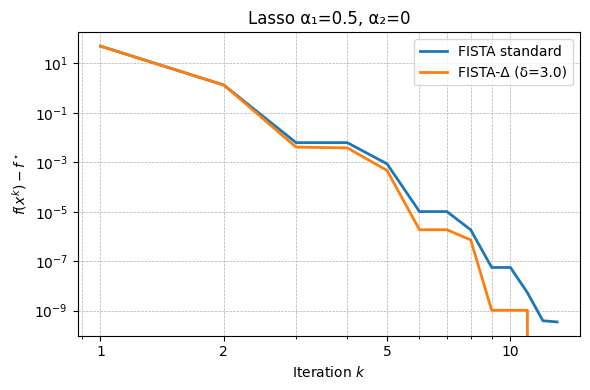

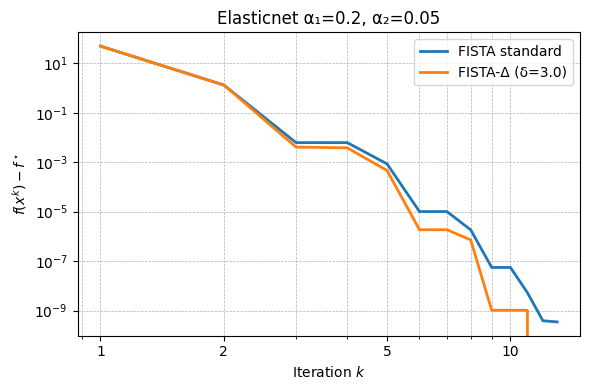

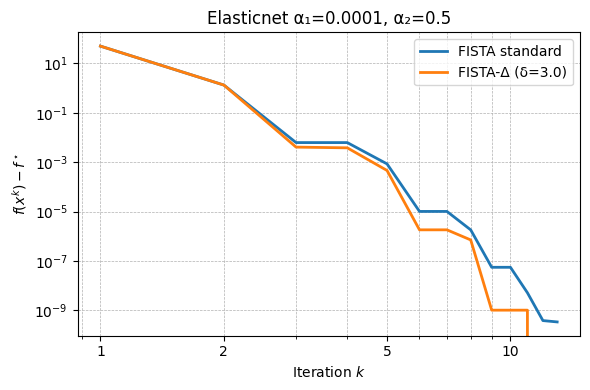

In [137]:
# Confronto FISTA vs FISTA-Delta per ogni setting valido
delta = 3.0
records_fista_variants = []

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    if name not in ("lasso", "elasticnet") or a1 < 1e-6:
        continue  # Skip smooth-only cases

    try:
        # FISTA standard
        t0 = time.perf_counter()
        x_std, obj_std = fista(A, b,
                               reg_type=name,
                               alpha1=a1,
                               alpha2=a2,
                               max_iter=500)
        t_std = time.perf_counter() - t0

        # FISTA-delta
        t0 = time.perf_counter()
        x_del, obj_del = fista_delta(A, b,
                                     reg_type=name,
                                     alpha1=a1,
                                     alpha2=a2,
                                     delta=delta,
                                     max_iter=500)
        t_del = time.perf_counter() - t0

        # f_star = best value among both
        f_star = min(obj_std[-1], obj_del[-1])

        # Salva i dati nella tabella
        records_fista_variants.append({
            "method": "FISTA",
            "delta": None,
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter": len(obj_std),
            "time_s": t_std,
            "f_final": obj_std[-1],
            "gap": obj_std[-1] - f_star,
            "error_norm": np.linalg.norm(x_std - x_true)
        })

        records_fista_variants.append({
            "method": "FISTA-DELTA",
            "delta": delta,
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter": len(obj_del),
            "time_s": t_del,
            "f_final": obj_del[-1],
            "gap": obj_del[-1] - f_star,
            "error_norm": np.linalg.norm(x_del - x_true)
        })

        # --- plot ---
        gap_std   = np.array(obj_std) - f_star
        gap_del   = np.array(obj_del) - f_star
        env_std   = np.minimum.accumulate(gap_std)
        env_del   = np.minimum.accumulate(gap_del)

        ks_std = np.arange(1, len(env_std)+1)
        ks_del = np.arange(1, len(env_del)+1)

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.loglog(ks_std, env_std, '-', label="FISTA standard", linewidth=2)
        ax.loglog(ks_del, env_del, '-', label=f"FISTA-Δ (δ={delta})", linewidth=2)

        ax.set_title(f"{name.title()} α₁={a1:.1g}, α₂={a2:.1g}")
        ax.set_xlabel("Iteration $k$")
        ax.set_ylabel(r"$f(x^k)-f^\star$")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()

        from matplotlib.ticker import LogLocator, FormatStrFormatter
        ax.xaxis.set_major_locator(LogLocator(base=10, subs=[1, 2, 5]))
        ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(1, 10), numticks=12))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"[{name.upper()}] Skipped FISTA/FISTA-delta comparison: {e}")


### ⚡ FISTA vs FISTA-Delta (δ = 3.0)

This table compares two accelerated first-order methods:

- **FISTA** (Fast Iterative Shrinkage-Thresholding Algorithm), which uses a standard Nesterov-style momentum based on a recursive parameter \( t_k \)
- **FISTA-Delta**, a variant that replaces the recursive update with a closed-form formula controlled by a constant \( \delta > 2 \)

#### 🔁 Inertial Parameter:

In FISTA-Delta, the momentum coefficient is:

\[
\theta_k = \frac{k}{k+1+\delta} \quad \text{with} \quad \delta = 3.0
\]

This provides a more stable inertial term, with the same theoretical convergence rate \( \mathcal{O}(1/k^2) \), and may improve practical performance in some settings.

Each row shows the behavior of one method (FISTA or FISTA-Delta) applied to a regularization configuration, with detailed metrics including objective gap, convergence, and error norm.

This lets us evaluate whether the modified momentum improves speed, stability, or accuracy in different regimes (Lasso, EN-1, EN-2, EN-3).


In [138]:
df_fista_variants = pd.DataFrame(records_fista_variants)

# 1. f* ottimo stimato per ogni combinazione (ignora metodo)
opt_per_group = df_fista_variants.groupby(["regularizer", "alpha1", "alpha2"])["f_final"].min().rename("f_opt")
df_fv = df_fista_variants.merge(opt_per_group, on=["regularizer", "alpha1", "alpha2"])

# 2. gap e convergenza
df_fv["gap"] = df_fv["f_final"] - df_fv["f_opt"]
df_fv["converged"] = df_fv["gap"] < 1e-6

# 3. classificazione in gruppi logici
def classify_group(row):
    if row["regularizer"] == "ridge":
        return "ridge"
    elif row["regularizer"] == "lasso":
        return "lasso"
    elif row["regularizer"] == "elasticnet":
        if np.isclose(row["alpha1"], 0.2, rtol=0, atol=1e-8):
            return "EN-1"
        elif np.isclose(row["alpha1"], 1e-4, rtol=0, atol=1e-8):
            return "EN-2"
        elif np.isclose(row["alpha1"], 0.0, rtol=0, atol=1e-12):
            return "EN-3"
        else:
            return "elasticnet-other"
    else:
        return row["regularizer"]

df_fv["reg_group"] = df_fv.apply(classify_group, axis=1)

# 4. metti reg_group subito dopo alpha2
cols = list(df_fv.columns)
idx_alpha2 = cols.index("alpha2")
cols = cols[:idx_alpha2+1] + ["reg_group"] + [c for c in cols if c not in cols[:idx_alpha2+1] + ["reg_group"]]
df_fv = df_fv[cols]

df_fv


,method,delta,regularizer,alpha1,alpha2,reg_group,n_iter,time_s,f_final,gap,error_norm,f_opt,converged
0,FISTA,NaN,lasso,0.5000,0.00,lasso,13,0.001844,7.108271,3.469047e-10,9.371145,7.108271,True
1,FISTA-DELTA,3.0,lasso,0.5000,0.00,lasso,13,0.000682,7.108271,0.000000e+00,9.371146,7.108271,True
2,FISTA,NaN,elasticnet,0.2000,0.05,EN-1,13,0.000820,5.749968,3.465059e-10,9.370963,5.749968,True
3,FISTA-DELTA,3.0,elasticnet,0.2000,0.05,EN-1,13,0.002764,5.749968,0.000000e+00,9.370963,5.749968,True
4,FISTA,NaN,elasticnet,0.0001,0.50,EN-2,13,0.001773,9.068880,3.412790e-10,9.372293,9.068880,True
5,FISTA-DELTA,3.0,elasticnet,0.0001,0.50,EN-2,13,0.000716,9.068880,0.000000e+00,9.372294,9.068880,True
